Importing python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mne.baseline import rescale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, permutation_test_score
plt.ion()

Defining variables

In [2]:
scoring = 'roc_auc' 
n_folds = 5
p_value_threshold = 0.05
n_permutations = 1000
solver = 'lbfgs'
n_jobs = -1

inputdir = 'data/'
subject_number = 1
filename_template = 'subject_%s_data_%s_%s.npz'

Defining the sliding time window (1 sec)

In [3]:
t_min = -0.5  
t_max = 6.5  
time_window_size = 1 
time_step = 1  
epsilon = 0.01 
t_mins = np.arange(t_min, t_max - time_window_size + epsilon, time_step)
t_maxs = np.arange(t_min + time_window_size, t_max + epsilon, time_step)
time_windows = list(zip(t_mins, t_maxs))
n_windows = len(t_mins)
timepoints = np.arange(0,n_windows,1)

Initialize variables

In [4]:
scores = np.zeros(n_windows)
significant = np.zeros(n_windows, dtype=bool)
permutations = np.zeros((n_windows,n_permutations))

Loading the data, training and testing the decoding model, and computing significance using a non-parametric permutation test for each time window

In [5]:
print(" ")
print("Cross-validated %s using signal in the time domain" % scoring)
for ii, (t_start, t_stop) in enumerate(time_windows):

    print(" ")
    print("time window %s - %s" % (t_start, t_stop))

    data = np.load(inputdir + filename_template % (subject_number, t_start, t_stop), allow_pickle=True)
    X = data['x']

    y = np.load(inputdir + 'subject_%s_ys.npy' % (subject_number), allow_pickle=True)[ii]

    X_time = np.hstack([X[:, ch, :] for ch in range(X.shape[1])])

    clf = LogisticRegression(solver=solver)
    cv = StratifiedKFold(n_splits=n_folds, random_state=0, shuffle=True)

    print("Computing %s permutations" % n_permutations)
    score, permutation_scores, p_value = permutation_test_score(clf, X_time, y, scoring=scoring, cv=cv, n_permutations=n_permutations, n_jobs=n_jobs)

    print("%s : %s" % (scoring, score))
    print("p_value = %s" % p_value)

    scores[ii] = score
    significant[ii] = p_value <= p_value_threshold
    permutations[ii] = permutation_scores

 
Cross-validated roc_auc using signal in the time domain
 
time window -0.5 - 0.5
Computing 1000 permutations
roc_auc : 0.6268518518518519
p_value = 0.09490509490509491
 
time window 0.5 - 1.5
Computing 1000 permutations
roc_auc : 0.5176094276094275
p_value = 0.4485514485514486
 
time window 1.5 - 2.5
Computing 1000 permutations
roc_auc : 0.5242857142857142
p_value = 0.3926073926073926
 
time window 2.5 - 3.5
Computing 1000 permutations
roc_auc : 0.44803767660910515
p_value = 0.7742257742257742
 
time window 3.5 - 4.5
Computing 1000 permutations
roc_auc : 0.5774104683195592
p_value = 0.1848151848151848
 
time window 4.5 - 5.5
Computing 1000 permutations
roc_auc : 0.47606837606837615
p_value = 0.6303696303696303
 
time window 5.5 - 6.5
Computing 1000 permutations
roc_auc : 0.5768315018315018
p_value = 0.13386613386613386


Plot results

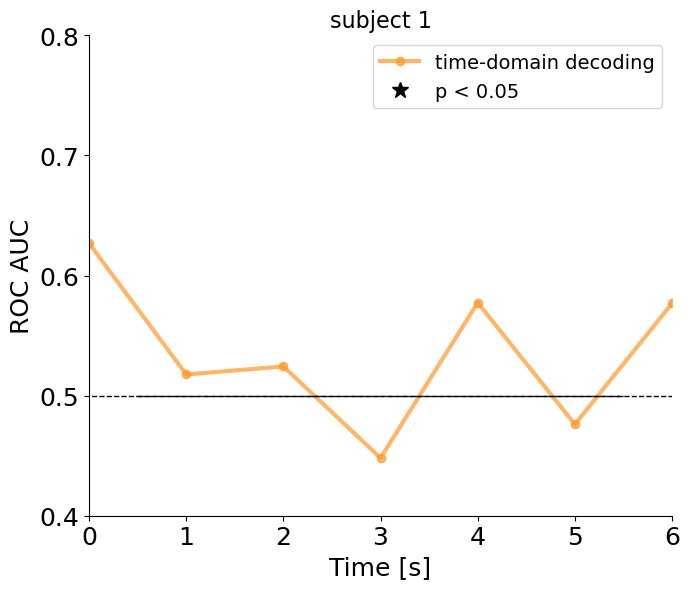

In [6]:
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
ax.plot(timepoints, scores, 'o-', color='#fe9929', lw=3, label='time-domain decoding', alpha=0.7)
if np.any(significant): 
    ax.plot(timepoints[significant], scores[significant], ' ', marker='*', color='k', markersize=12, label='p < 0.05')
else:
    ax.plot(0, 0, ' ', marker='*', color='k', markersize=12, label='p < 0.05')
ax.plot(time_windows, np.ones(n_windows) * 0.5, '--', lw=1, color='black')
ax.set_ylabel('ROC AUC', fontsize=18)
ax.set_xlabel('Time [s]', fontsize=18)
ax.set_ylim([0.4, 0.8])
ax.set_xlim([0.0, 6.0])
ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])
ax.set_yticklabels([0.4, 0.5, 0.6, 0.7, 0.8])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.legend(loc=0, fontsize=14)
ax.tick_params(labelsize=18)
ax.set_title('subject %s' % (subject_number), fontsize=16)
plt.tight_layout()